<a href="https://colab.research.google.com/github/Jieoi/traffic_sign_recognition/blob/updating_markdown/4_test_data_preparation_RRDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: This instance of Google Colab has been configured to use the standard CPU.

Note: The code below has been configured to run on Google colab with python scripts imported from google drive. Please download the scripts from [here](https://drive.google.com/drive/folders/1nViTcpc952b0ftRGqkDBFqbSEC01t0a8). Files required including all scripts and helper files under data_preparation folder and data_augmentation folder. Alternatively, vist my github repository to [download](https://github.com/Jieoi/traffic_sign_recognition/tree/main) the scripts and helper files.

<h2>4. Data enhancement using RRDB</h2>

Some libraries are used in this notebook

In [ ]:
# File and system handling
import os
import shutil
import sys

# Data handling and plotting
import pandas as pd
import matplotlib.pyplot as plt

# Image processing, including numpy images array
from PIL import Image
import cv2
import numpy as np

# Zipping files
import zipfile

Similar to the rest of the notebooks, the google drive is first mounted to access the data

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('drive', force_remount=True)

Mounted at drive


<h2>4.1 Extract the zip file</h2>

Files are obtained from the zip file using the extract_zip_to_directory function from the getFile.py. The source code is first extracted from the Google Drive.


In [ ]:
# Define the path to the getFile.py script
script_path = 'drive/MyDrive/final/data_preparation/getFile.py'

# Add the script directory to sys.path to import the module
script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

extract_zip_to_directory is imported and called:

In [ ]:
# Import the extract_zip_to_directory function from getFile.py
from getFile import extract_zip_to_directory

# Define file paths
root_path = 'drive/MyDrive'
zip_filename = os.path.join(root_path, 'GTSRB/GTSRB.zip')
extract_dir = "GTSRB"

# Call the function
extract_zip_to_directory(zip_filename, extract_dir)

Extraction complete.


Test data and their corresponding labels (ground truth) where obtained from the folders using the getData.py

In [ ]:
# Assign the paths
ground_truth = os.path.join(extract_dir, 'GTSRB', 'GTSRB_Final_Test_GT', 'GT-final_test.csv')
test_directory = os.path.join(extract_dir, 'GTSRB', 'GTSRB_Final_Test_Images', 'GTSRB', 'Final_Test', 'Images')

print("ground_truth:", ground_truth)
print("test_directory:", test_directory)

ground_truth: GTSRB/GTSRB/GTSRB_Final_Test_GT/GT-final_test.csv
test_directory: GTSRB/GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images


In [ ]:
# Define the path to the getFile.py script
script_path = 'drive/MyDrive/final/data_preparation/getData.py'

# Add the script directory to sys.path to import the module
script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

import getData

In [ ]:
images = getData.load_testing_images(test_directory)
labels = getData.load_ground_truth(ground_truth)

Skipping file GTSRB/GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/GT-final_test.test.csv: cannot identify image file 'GTSRB/GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/GT-final_test.test.csv'
Loaded 12630 test images in 2.055046558380127 seconds.


<h2> 4.2 Simple statictics</h2>

Similar to chapter 3.2, statictics are calculated from the labels

In [ ]:
images.shape

(12630, 32, 32, 3)

The original size of the images is 32x32 pixels in shape. The images will be resized to 128 by 128 pixels by the end of this notebook.

The first few rows of the labels dataframe is displayed below.

In [ ]:
labels.head()

Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId
0  00000.ppm     53      54       6       5      48      49       16
1  00001.ppm     42      45       5       5      36      40        1
2  00002.ppm     48      52       6       6      43      47       38
3  00003.ppm     27      29       5       5      22      24       33
4  00004.ppm     60      57       5       5      55      52       11

The statictics of the labels are calculated in the same way as chapter 3.2

In [ ]:
def calculate_column_statistics(df, column_name):
    """
    Calculate statistics for a DataFrame's column.

    Parameters:
    - df: DataFrame containing the data.
    - column_name: Name of the column to calculate statistics for.

    Returns:
    A dictionary containing the calculated statistics.
    """
    # Extract the specified column
    column_data = df[column_name]

    # Calculate the label distribution
    unique_values, value_counts = np.unique(column_data, return_counts=True)
    value_distribution = dict(zip(unique_values, value_counts))

    # Extract values and counts from the value distribution dictionary
    values_list = list(value_distribution.keys())
    counts = list(value_distribution.values())

    # Sort values and counts by value names
    sorted_indices = np.argsort(values_list)
    values_list = np.array(values_list)[sorted_indices]
    counts = np.array(counts)[sorted_indices]

    # Calculate statistics
    total_values = sum(counts)
    average_values = total_values / len(unique_values)
    median_values = np.median(counts)
    std_deviation = np.std(counts)
    min_index = np.argmin(counts)
    max_index = np.argmax(counts)

    # Get values for minimum and maximum counts
    min_value = values_list[min_index]
    max_value = values_list[max_index]
    min_count = counts[min_index]
    max_count = counts[max_index]

    # Return statistics as a dictionary
    statistics = {
        "average count": average_values,
        "median count": median_values,
        "standard deviation": std_deviation,
        "min value": min_value,
        "max value": max_value,
        "min count": min_count,
        "max count": max_count,
    }

    return statistics

The same goes to the plot_label_distribution function.

In [ ]:
def plot_label_distribution(df, column_name):
    """
    Create a bar plot for label distribution in a DataFrame's column.

    Parameters:
    - df: DataFrame containing the data.
    - column_name: Name of the column to plot the distribution for.

    Returns:
    None
    """
    # Extract the specified column
    labels = df[column_name]

    # Calculate the label distribution
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique_labels, label_counts))

    # Extract labels and counts from the label distribution dictionary
    labels_list = list(label_distribution.keys())
    counts = list(label_distribution.values())

    # Sort labels and counts by label names
    sorted_indices = np.argsort(labels_list)
    labels_list = np.array(labels_list)[sorted_indices]
    counts = np.array(counts)[sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.bar(labels_list, counts, tick_label=labels_list, color='skyblue')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title(f'Distribution of {column_name}')
    plt.xticks(labels_list, rotation=45)
    plt.tight_layout()

    plt.show()

The distribution of the labels is plotted below. The plot shows a similar distribution as chapter 3.2.

This also showed a **very imbalanced** distribution of the labels.

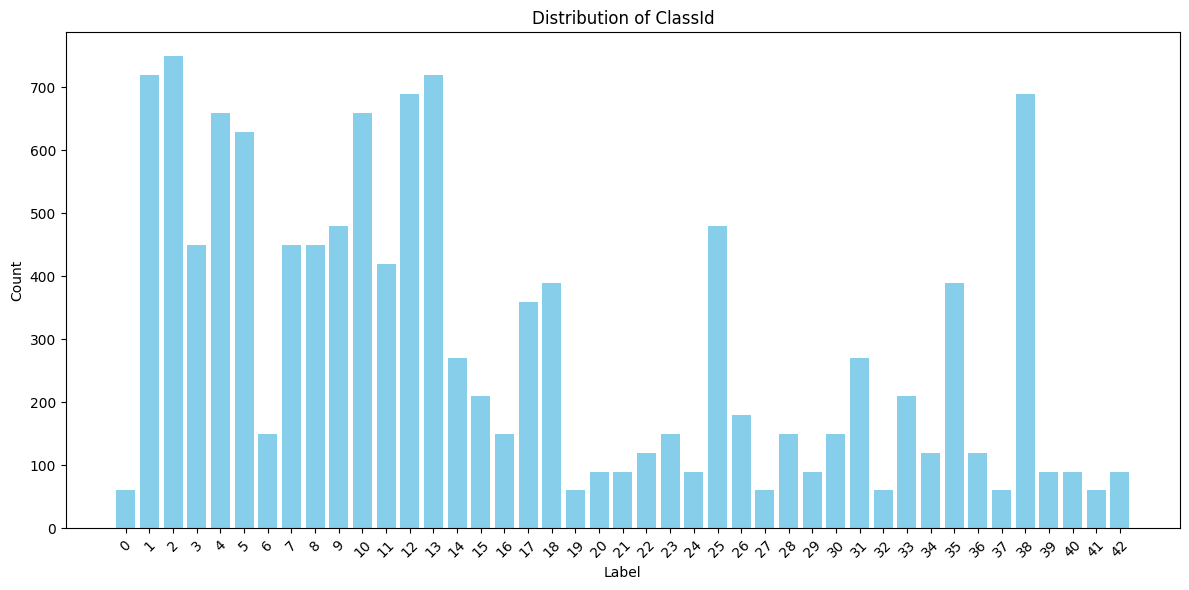

In [ ]:
plot_label_distribution(labels, 'ClassId')

The identical statistics for labels is shown as compared to chapter 3.2. This showed that the **exactly the same** data is extracted.

In [ ]:
statistics = calculate_column_statistics(labels, 'ClassId')
print(statistics)

{'average count': 293.72093023255815, 'median count': 180.0, 'standard deviation': 230.71197442551764, 'min value': 0, 'max value': 2, 'min count': 60, 'max count': 750}


Given that the same data is extracted, the data augmentation will be performed in the same way as chapter 3.2.

All classes will be augmented to exactly **293 images**.

<h2>4.3 Image enhancement and data augmentation</h2>

Note: Due to the large number of image data, this data processing could **take up to 3 hours** to complete on Google Colab. You are strongly recommended to run the code using a smaller set of data first.

Images loaded in this notebook will be enhanced using the ESRGAN model. For simplicity in deployment, the data is saved in the 'test_images' folder which is similar to the requirement of the ESRGAN model.

The low quality images are saved to the 'test_images' folder as **png format** so that it can be enhanced using the ESRGAN model directly via a small modification of the testing code from the ESRGAN model here: [github repository](https://github.com/xinntao/ESRGAN/blob/master/test.py).

In [ ]:
# Create a directory named 'test_images' if it doesn't exist
if not os.path.exists('test_images'):
    os.makedirs('test_images')

images = (images * 255).astype(np.uint8)  # Convert to uint8 in the range 0-255

for i in range(images.shape[0]):
    img = Image.fromarray(images[i])
    label = labels.iloc[i]['ClassId']
    img.save(f'test_images/image_{i}_label_{label}.png')

print("Images saved to 'test_images' folder.")

Images saved to 'test_images' folder.


One image from each class is shown using the code below. Unlike chapter 3.2, the images is displayed by loading them directly from the 'test_images' folder.

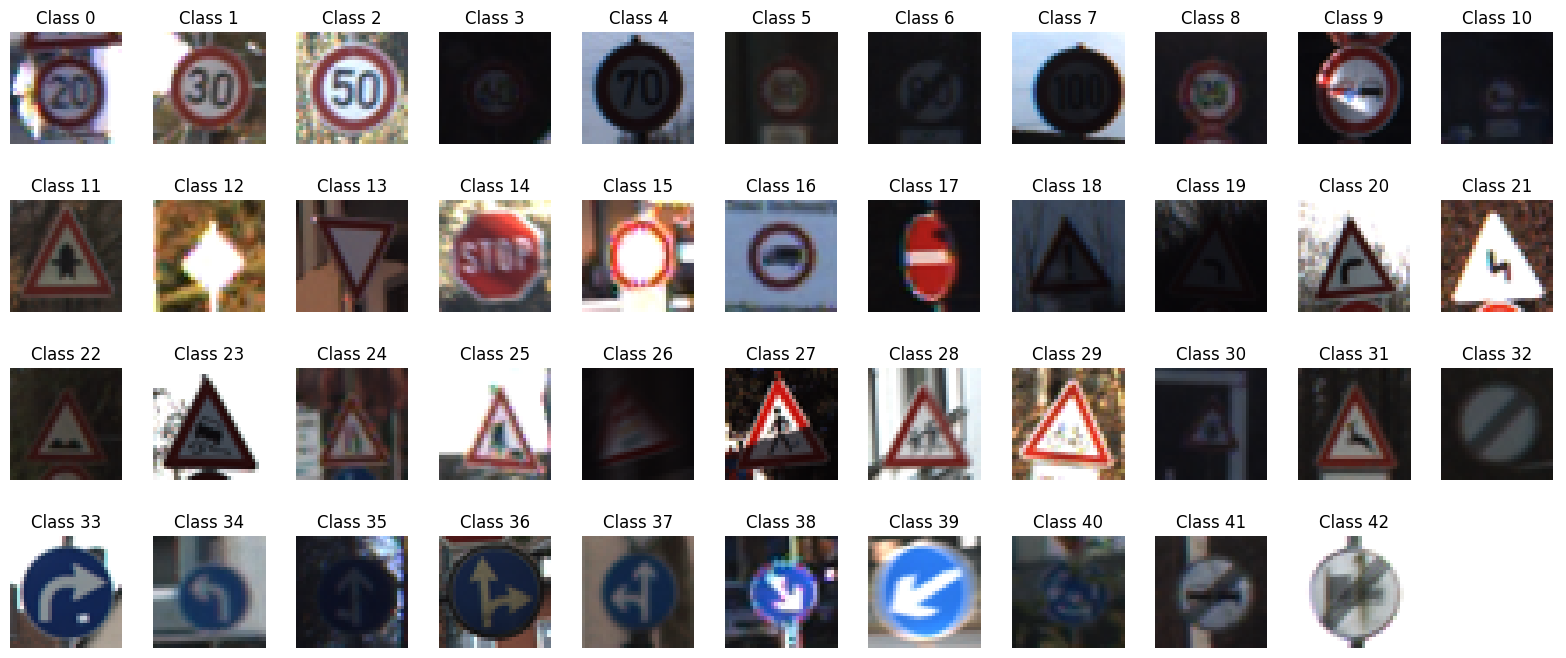

In [ ]:
# Locate the test_images directory
image_directory = 'test_images'

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_directory) if f.endswith('.png')]

# Create a dictionary to store one image per class
class_images = {}

# Iterate through the image files and store one image per class
for image_file in image_files:
    label = int(image_file.split('_label_')[1].split('.png')[0])
    if label not in class_images:
        class_images[label] = os.path.join(image_directory, image_file)

#  Get the reversely sorted dictionary
class_images = dict(sorted(class_images.items(), reverse=True))

# Create a 4x11 subplot grid
fig, axes = plt.subplots(4, 11, figsize=(20, 8))
fig.subplots_adjust(hspace=0.5)

# Iterate through the class images and display them in the grid
for i in range(4):
    for j in range(11):
        ax = axes[i, j]
        ax.axis('off')

        # Check if there are remaining class images to display
        if class_images:
            label, image_path = class_images.popitem()
            img = plt.imread(image_path)
            ax.imshow(img)
            ax.set_title(f'Class {label}')

# 43 classes in total but 44 boxes drawn, remove the rest
for i in range(4):
    for j in range(11):
        if not class_images:
            break
        ax = axes[i, j]
        fig.delaxes(ax)

plt.show()

<h2>4.3.1 Load data enhancement model</h2>

The ESRGAN model is first loaded from the drive. This model is obtained from the [github repository](https://github.com/xinntao/ESRGAN).

For the ease of deployment, the model is saved in my [Google Drive](https://drive.google.com/drive/folders/19XTL-a_RDiuqYzFpwsJgta5JKU3aiCp0).

In [ ]:
# Copy RRDBNet_arch.py and RRDB_ESRGAN_x4.pth to the models directory
models_directory = 'models'
os.makedirs(models_directory, exist_ok=True)

# Copy RRDBNet_arch.py
source_arch_path = 'drive/MyDrive/final/pre-trained-model/RRDBNet_arch.py'
target_arch_path = os.path.join(models_directory, 'RRDBNet_arch.py')
shutil.copy(source_arch_path, target_arch_path)

# Copy RRDB_ESRGAN_x4.pth
source_model_path = 'drive/MyDrive/final/pre-trained-model/RRDB_ESRGAN_x4.pth'
target_model_path = os.path.join(models_directory, 'RRDB_ESRGAN_x4.pth')
shutil.copy(source_model_path, target_model_path)


'models/RRDB_ESRGAN_x4.pth'

The testing code for ESRGAN is edited in the enhance_images_RRDB.py so that the model can be loaded and deployed here. The original code for testing of ESRGAN can be found here: [github repository](https://github.com/xinntao/ESRGAN/blob/master/test.py).

In [ ]:
# Define the path to the getFile.py script
script_path = 'drive/MyDrive/final/data_augmentation/enhancing_image_RRDB.py'

# Add the script directory to sys.path to import the module
script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

import enhancing_image_RRDB

Using the code imported, the raw images are enhaced by the ESRGAN model via the enhance_images_RRDB function.

In [ ]:
# Call the function with the desired inputs
img_folder = '/content/test_images/*'
output_dir = '/content/test_images_enhanced'
model_path = '/content/drive/MyDrive/final/pre-trained-model/RRDB_ESRGAN_x4.pth'

enhancing_image_RRDB.enhance_images_rrdb(img_folder, output_dir, model_path)

Streaming output truncated to the last 5000 lines.
7631 image_12227_label_21
7632 image_11771_label_0
7633 image_4329_label_35
7634 image_5518_label_27
7635 image_10306_label_2
7636 image_2145_label_4
7637 image_1_label_1
7638 image_5733_label_1
7639 image_3344_label_12
7640 image_1901_label_10
7641 image_7413_label_5
7642 image_10124_label_11
7643 image_2293_label_10
7644 image_2878_label_13
7645 image_11045_label_19
7646 image_6354_label_5
7647 image_6445_label_11
7648 image_7140_label_12
7649 image_3069_label_13
7650 image_5317_label_35
7651 image_6389_label_10
7652 image_7375_label_31
7653 image_7504_label_42
7654 image_1485_label_12
7655 image_3586_label_18
7656 image_4949_label_13
7657 image_9854_label_29
7658 image_1861_label_42
7659 image_7366_label_14
7660 image_2017_label_7
7661 image_8982_label_2
7662 image_4043_label_26
7663 image_9084_label_3
7664 image_11801_label_11
7665 image_1505_label_13
7666 image_416_label_10
7667 image_9598_label_2
7668 image_4713_label_13
7669 ima

To illustrate the output of the enhancement, a comparision of one original and enhanced image is shown below.

i can be modified to any value below 12630 to see difference before and after enhancement.

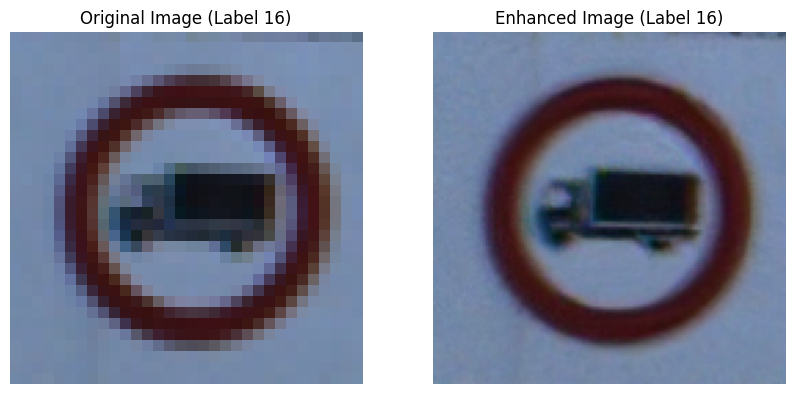

In [ ]:
# Modify i to see different images
i = 0

enhanced_image_folder = 'test_images_enhanced'

img = Image.fromarray(images[i])
label = labels.iloc[i]['ClassId']  # Assuming 'ClassId' is the column with labels
img.save(f'test_images/image_{i}_label_{label}.png')

# Load the enhanced image
enhanced_image_path = os.path.join(enhanced_image_folder, f'image_{i}_label_{label}_enhanced.png')
enhanced_img = Image.open(enhanced_image_path)

# Display the original and enhanced images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f'Original Image (Label {label})')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Enhanced Image (Label {label})')
plt.imshow(enhanced_img)
plt.axis('off')

plt.show()

From the output above, a much clearer image is obtained.

Thus, the enhanced images are read and loaded as list of numpy arrays for further processing.

In [ ]:
# Initialize variables and empty lists
folder_path = "/content/test_images_enhanced"
enhanced_images = []
enhanced_labels = []

In [ ]:
# Load the enhanced images
for filename in os.listdir(folder_path):
    if filename.endswith("_enhanced.png"):
        # Extract the label from the filename
        parts = filename.split("_")
        if len(parts) >= 3 and parts[-1] == "enhanced.png":
            label = int(parts[-2])
            image_path = os.path.join(folder_path, filename)

            # Read the image using PIL
            img = Image.open(image_path)

            # Convert the image to a numpy array
            img_array = np.array(img)

            enhanced_images.append(img_array)
            enhanced_labels.append(label)

enhanced_images = np.array(enhanced_images)
enhanced_labels = np.array(enhanced_labels)

The array of enhanced images and labels are checked below for some simple statistics.

In [ ]:
# Check the shape of the enhanced images array
enhanced_images.shape

(12630, 128, 128, 3)

In [ ]:
# Check the shape of the enhanced labels array
enhanced_labels.shape

(12630,)

It was noted that the size of images has **increased** to 128 by 128. The length/number of images remains constant.

A sample of the enhanced images from the same class is shown below.

The variable label_to_visualize can be adjusted to any value below 43 to see different classes.

The aim of this code is to check whether the images and the labels are **linked correctly**.

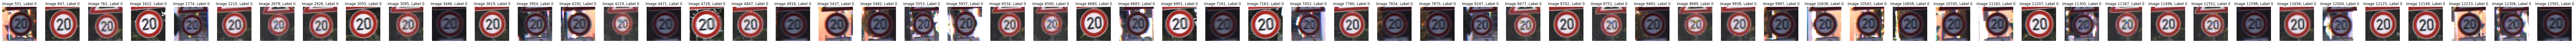

In [ ]:
# Define the label to visualize
label_to_visualize = 0

# Find the indices of images with the specified label in selected_labels
indices_with_label = np.where(enhanced_labels == label_to_visualize)[0]

# Create a subplot grid for displaying images
num_images_to_display = len(indices_with_label)
num_rows = 1
num_cols = num_images_to_display

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, 2))

# Loop through and display each image
for i, index in enumerate(indices_with_label):
    ax = axes[i]
    image = enhanced_images[index]
    ax.imshow(image)
    ax.set_title(f"Image {index}, Label {label_to_visualize}")
    ax.axis("off")

plt.tight_layout()
plt.show()

Note: Please refer to the [Google Colab](https://colab.research.google.com/drive/1MUX8cdZOqvXvtRso9PiDPGpAm8zy52Ux#scrollTo=ynA0luXojt3k) instance to view the images above. Github may not be able to display the images correctly.

<h2>4.3.2 Image Augmentations</h2>

The same data augmentation method as the training code is applied to the enhanced images.

In [ ]:
def apply_augmentations(image):
    augmented_image = image.copy()

    # Rotation
    angle = np.random.uniform(-45, 45)  # Rotate by up to 45 degrees
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    augmented_image = cv2.warpAffine(augmented_image, rotation_matrix, (width, height))

    # Zooming
    scale = np.random.uniform(0.8, 1.2)  # Zoom in/out by up to 20%
    zoom_matrix = np.array([[scale, 0, 0], [0, scale, 0]])
    augmented_image = cv2.warpAffine(augmented_image, zoom_matrix, (width, height))

    # Contrast adjustment
    alpha = np.random.uniform(0.95, 1.05)  # Adjust contrast by up to 5%
    beta = np.random.uniform(-1, 1)   # Adjust brightness by up to 1 units
    augmented_image = cv2.convertScaleAbs(augmented_image, alpha=alpha, beta=beta)

    return augmented_image

In [ ]:
# Define the desired data size
desired_data_size = 293

# Initialize a list to store augmented images and labels
augmented_images = []
augmented_labels = []

# Loop through each unique label
unique_labels = np.unique(enhanced_labels)
for label in unique_labels:
    # Find indices of images with the current label
    label_indices = np.where(enhanced_labels == label)[0]

    # Calculate how many images to generate for this label
    num_images_to_generate = desired_data_size - len(label_indices)

    # Loop to generate augmented images for this label
    for _ in range(num_images_to_generate):
        # Randomly select an image with the current label
        random_image_index = np.random.choice(label_indices)
        image_to_augment = enhanced_images[random_image_index]

        # Apply augmentations and append to the list
        augmented_image = apply_augmentations(image_to_augment)
        augmented_images.append(augmented_image)
        augmented_labels.append(label)

# Convert the lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [ ]:
# Concatenate the augmented_images with enhanced_images
final_images = np.concatenate([enhanced_images, augmented_images], axis=0)

# Concatenate the selected_labels with augmented_labels
final_labels = np.concatenate([enhanced_labels, augmented_labels], axis=0)

In [ ]:
final_images.shape

(17008, 128, 128, 3)

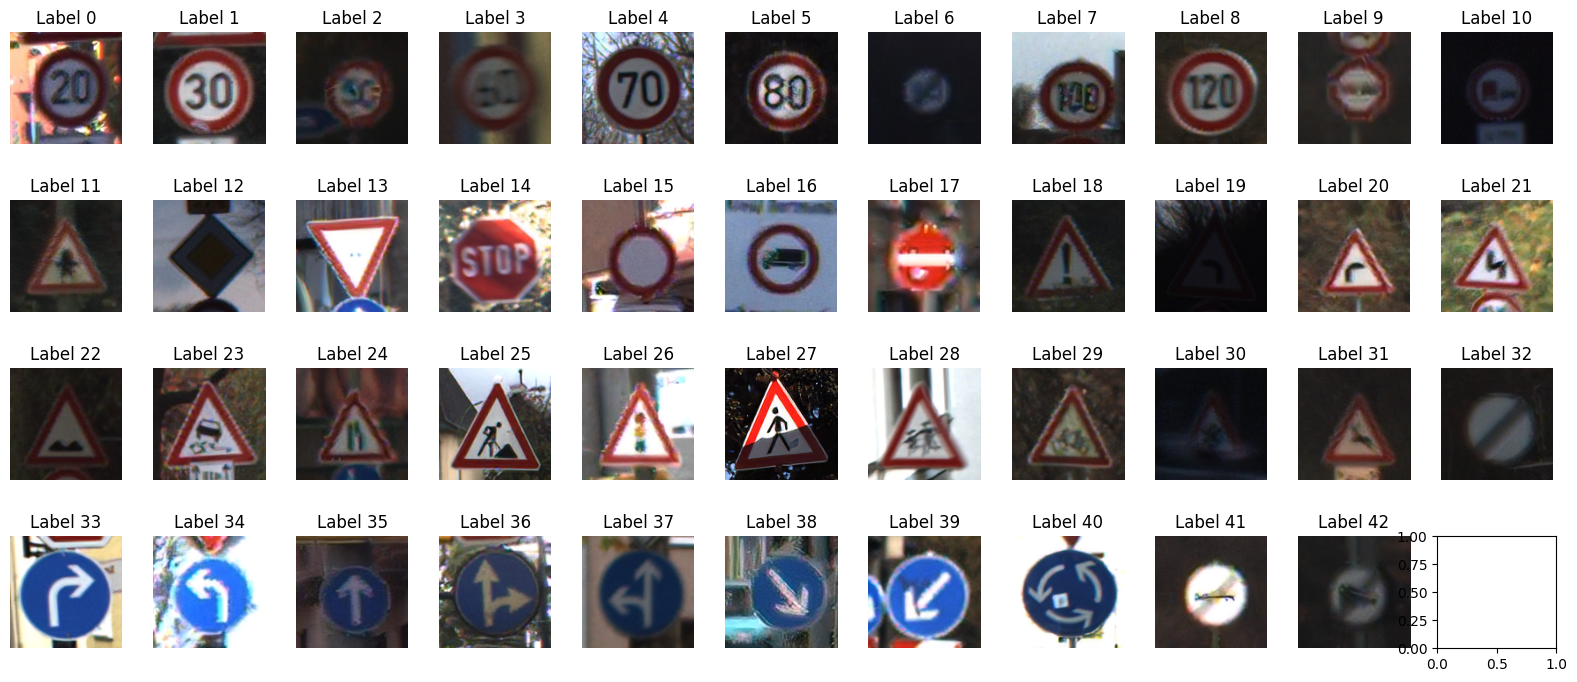

In [ ]:
# Get unique labels
unique_labels = np.unique(final_labels)

# Create a 4x11 grid of subplots
fig, axes = plt.subplots(4, 11, figsize=(20, 8))
fig.subplots_adjust(hspace=0.5)

# Initialize counters for rows and columns
row, col = 0, 0

# Iterate through unique labels and select one image per label
for label in unique_labels:
    # Find the first index where the label appears in 'final_labels'
    index = np.where(final_labels == label)[0][0]

    # Get the corresponding image
    image = final_images[index]

    # Display the image in the current subplot
    axes[row, col].imshow(image)
    axes[row, col].set_title(f'Label {label}')
    axes[row, col].axis('off')

    # Move to the next column
    col += 1

    # Move to the next row and reset the column counter
    if col == 11:
        col = 0
        row += 1

    # displayed all images, break
    if row == 4:
        break

# Remove any empty subplot there are 43unique labels
for i in range(row + 1, 4):
    for j in range(11):
        fig.delaxes(axes[i, j])

plt.show()

In [ ]:
# Create a list of unique class labels
unique_labels = np.unique(final_labels)

# Initialize lists to store the filtered images and labels
filtered_images = []
filtered_labels = []

# Loop through each unique class label
for label in unique_labels:
    # Get the indices of images with the current class label
    class_indices = np.where(final_labels == label)[0]

    # Shuffle the indices randomly
    np.random.shuffle(class_indices)

    # Keep the first indices then add them to the filtered data until the desired number
    filtered_images.extend(final_images[class_indices[:desired_data_size]])
    filtered_labels.extend(final_labels[class_indices[:desired_data_size]])

# Convert the filtered data back to NumPy arrays
filtered_images = np.array(filtered_images)
filtered_labels = np.array(filtered_labels)

# Check the shape of the filtered data
print("Filtered Images Shape:", filtered_images.shape)
print("Filtered Labels Shape:", filtered_labels.shape)

Filtered Images Shape: (12599, 128, 128, 3)
Filtered Labels Shape: (12599,)


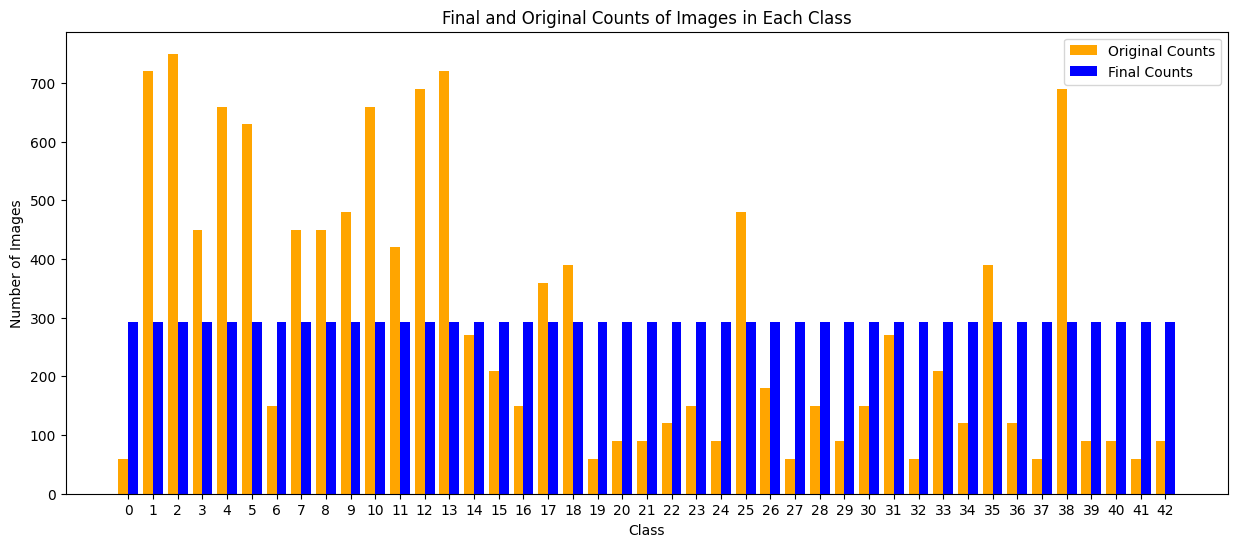

In [ ]:
# Calculate the counts of images in each class for both final and original data
final_class_counts = np.bincount(filtered_labels)
original_class_counts = np.bincount(labels["ClassId"])

# Number of classes
num_classes = len(final_class_counts)

# Create an array of class labels
class_labels = np.arange(num_classes)

# Calculate the bar width and the gap between original and final counts
bar_width = 0.4
gap = 0.2

# Calculate the positions for the bars
original_bar_positions = class_labels * (2 * bar_width + gap) - bar_width / 2
final_bar_positions = class_labels * (2 * bar_width + gap) + bar_width / 2

# Plot the graph
plt.figure(figsize=(15, 6))

# Plot original counts in orange
plt.bar(original_bar_positions, original_class_counts, color='orange', width=bar_width, label='Original Counts')

# Plot final counts in blue
plt.bar(final_bar_positions, final_class_counts, color='blue', width=bar_width, label='Final Counts')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Final and Original Counts of Images in Each Class')
plt.xticks(class_labels * (2 * bar_width + gap), class_labels)  # Adjust xticks positions
plt.legend()
plt.show()

In [ ]:
# Define the directory to save the images
save_directory = "test_images_augmented"

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Iterate through the images and labels
for i, (image, label) in enumerate(zip(filtered_images, filtered_labels)):
    # Create the file name using the specified format
    file_name = f"image_{i}_label_{label}_augmented.png"

    # Save the image to the directory
    file_path = os.path.join(save_directory, file_name)
    image_pil = Image.fromarray(image)
    image_pil.save(file_path)

print(f"Saved {len(filtered_images)} augmented images to '{save_directory}' directory.")

Saved 12599 augmented images to 'test_images_augmented' directory.


In [ ]:
source_folder = 'test_images_augmented'
destination_folder = 'drive/My Drive/final/test_data'

# Create a zip file of the source folder
shutil.make_archive(destination_folder + '/test_images_enhanced_PIL_RRDB', 'zip', source_folder)


'/content/drive/My Drive/final/test_data/test_images_enhanced_PIL_RRDB.zip'

In [ ]:
# # Specify the path to the folder you want to delete entries from
# folder_path = 'test_images_augmented'

# # List all files in the folder
# folder_contents = os.listdir(folder_path)

# # Iterate through the files and delete them
# for item in folder_contents:
#     item_path = os.path.join(folder_path, item)
#     if os.path.isfile(item_path):
#         os.remove(item_path)
#     elif os.path.isdir(item_path):
#         shutil.rmtree(item_path)

# print("All entries in 'test_images_augmented' have been deleted.")

All entries in 'test_images_augmented' have been deleted.
